# Version 5

### L'objectif est d'améliorer le cadre de simulation afin de pouvoir implémenter un algo plus fin qui prend en compte la vitesse des br

Pour réponse à la problématique d'épuiser tout le budget avant la fin de la journée, il faut pouvoir garantir un achat massif des br si jamais celles-ci venaient à se ralentir (pour être sur d'en avoir assez avant la fin de la journée pour épuiser tout el budget).

La première étape consiste donc à remodifier légèrement le cadre de la simulation en prenant en compte des effets d'affluence qui permettraient de faire varier la fréquence des br en plus du nb de panneaux dispo. Par exemple on pourrait imaginer avoir des creux de 3h en début, milieu ou fin de journée et ainsi simuler le ralentissement dans l'arrivée des bid requests. 

Une fois cela réalisé, on pourrait modifier le calcul de $b_t$ en prenant en compte justement les effets de vitesse et d'accélération. On pourrait à juste titre prendre en compte la vitesse de $b_t$ dans son calcul puisque ce dernier est directement lié à la vitesse d'arrivée des br (plus la vitesse d'arrivée des br est faible, plus la différence $b_{t+1} - b_t$ est grande.

Rappelons qu'on à la formule suivante : 
$$b_{t+1} = \Bigr(B - \sum_{s=1}^{t} S(s)\Bigl) \dfrac{1}{T-t}$$

Si nous prenons un temps continu, la vitesse de $b_t$ est mesuré par $v_t = \dfrac{b_{t+1} - b_t}{\partial b_t}$. Or étant en temps discret, au niveau d'une seconde le calcul est simplement le suivant : $v_t = b_{t+1} - b_t$.

De la même manière, l'accélération étant la dérivée seconde, on peut ici déterminer : $a_t = v_{t+1}-v_t$

L'idée est ensuite la suivante : on pourrait imaginer regarder une moyenne mobile de la vitesse sur un certain laps de temps (10min, 30min, 1h?) et utiliser cette moyenne pour la faire intervenir dans le calcul de $b_t$ directement. On aurait donc une nouvelle formule du type : 
$$b_{t+1} = \Bigr(B - \sum_{s=1}^{t} S(s)\Bigl) \dfrac{1+\alpha \overline{v_t}}{T-t}$$
où finalement $\overline{v_t}$ serait une moyenne mobile de $v_t$ et $\alpha$ un paramètre que l'on pourrait fixer en fonction des simulations. A termes, on pourrait même imaginer avoir quelque chose de la même forme mais où le $\alpha$ dépendrait de l'accélération tel que : $\alpha = \beta \times \overline{a_t}$ où là encore on pourrait fixer $\beta$.

### Import des librairies

In [1]:
import numpy as np
import random 
import simpy
import time
import csv
from collections import namedtuple
from datetime import datetime
import pandas as pd
from scipy.interpolate import interp1d
from statistics import mean
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

### Fonctions internes à la simulation

In [6]:
def imps():
    """Fonction qui génère un nombre d'impressions devant un panneau"""
    lam = int(np.random.normal(loc=4, scale=2, size=1))
    if lam < 1:
        lam = 1
    nb_imp = np.random.poisson(lam)
    return nb_imp

In [7]:
def delai(lam):
    """Fonction qui génère un nombre de secondes avant la prochaine br grâce à une loi de poisson de paramètre lambda"""
    secondes = np.random.poisson(lam)
        
    #Simuler une proba de pb technique (1% de chance d'en avoir un)
    if not random.random() < 0.99:
        secondes = np.random.poisson(secondes + 1000)
    return secondes

In [8]:
def total_sec(nb_jours):
    """Fonction pour générer le nombre de secondes contenu dans X jours"""
    tot = nb_jours * 86400
    return tot

In [9]:
def sauvegarde(liste, nom_de_fichier):
    """Fonction pour sauvegarder un named tuple dans un format CSV"""
    with open(nom_de_fichier, "w", encoding="utf8") as fichier:
        #Recuperer le nom des colonnes pour la première ligne
        premier, *_ = liste
        ecrivain = csv.DictWriter(fichier, premier._fields)
        ecrivain.writeheader()
        for br in liste:
            # On ecrit chaque ligne comme un ordered dict
            ecrivain.writerow(br._asdict())

### Algorithme sans prendre en compte la vitesse

In [6]:
def open_rtb_pacing(env, P, B, timestampnow, nb_jours, nb_hours_per_day, bidrequests, data):
    """Fonction pour générer la simulation"""
    setup = True
    identifiant = 0
    cible = B/(nb_hours_per_day*3600)
    current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
    while True:
        # Déterminer dans quel état on est actuellement
        if current_hour >= 6 and current_hour < 20:
            if setup:
                setup = False
                lambdas_seuils = np.array([5,1,400,1,50])
                timestamps_seuils = np.array([env.now,env.now+21600,env.now+32400,env.now+39600,env.now+54000])
                f_lambdas = interp1d(timestamps_seuils, lambdas_seuils)
                current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
                S = list()
                end_day = env.now + (nb_hours_per_day*3600) - 1200 #On fixe la fin de la journée à 19h40h pour être plus restrictif
            
            # Génération d'une br
            identifiant += 1
            rt = (timestampnow+total_sec(nb_jours))-env.now
            
            # Déterminer b_t
            try:
                bt = (B - sum(S))/(end_day - env.now)
                
            except ZeroDivisionError:
                bt = 1
            #on force l'achat
            if bt < 0:
                bt=1
            
            #Timestamp de la br
            time = datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S")

            # Nombre d'impressions
            nb_imp = imps()
            Prix = P * nb_imp
            
            #Achat ou non 
            if bt >= cible and (sum(S)+Prix) <= B:
                S.append(Prix)
                achat = 1
            else:
                achat = 0

            # Stocker les résultats dans le namedtuple puis ajout à une liste
            resultats = bidrequests(
                identifiant = identifiant,
                timestamp = env.now,
                timestamp_string = time,
                nombre_impressions = nb_imp,
                prix_impression = P,
                prix_total = Prix,
                achat = achat,
                budget_depense = sum(S),
                bt = bt,
                cible = cible
            )
            data.append(resultats)

            # Temps avant la prochaine BR
            time_before_next = delai(f_lambdas(env.now))


            # Fin de la simulation
            if rt < time_before_next:
                print(f"Fin de la simulation à {time} !")

            yield env.timeout(time_before_next)
            
            # Detecter quelle heure est-t-il
            if datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour != current_hour:
                current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour

        else:
            setup = True
            current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
            time = datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S")
            rt = (timestampnow+total_sec(nb_jours))-env.now
            if rt <= 1:
                print(f"Fin de la simulation à {time} !")
            yield env.timeout(1) 

In [7]:
# Constants globales
nb_days = 30
prix_per_imp = 1
Budget_par_jour = 3000

In [9]:
timestampnow = int(time.time()-3600*10)
bidrequests =  namedtuple(
    "bidrequests", 
    (
        "identifiant", 
        "timestamp", 
        "timestamp_string",
        "nombre_impressions",
        "prix_impression",
        "prix_total",
        "achat",
        "budget_depense",
        "bt",
        "cible"
    )
                    )
data = list()
env = simpy.Environment(initial_time=timestampnow)
proc = env.process(open_rtb_pacing(env, prix_per_imp, Budget_par_jour, timestampnow, nb_days, 14, bidrequests, data))
env.run(until=timestampnow + total_sec(nb_days))

Fin de la simulation à 08-01-2020 05:02:12 !


In [10]:
sauvegarde(data, 'sans_vitesse.csv')

### Algo avec prise en compte de la vitesse

In [11]:
def open_rtb_pacing_vitesse(env, P, B, timestampnow, nb_jours, nb_hours_per_day, bidrequests, data):
    """Fonction pour générer la simulation"""
    setup = True
    identifiant = 0
    cible = B/(nb_hours_per_day*3600)
    current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
    while True:
        # Déterminer dans quel état on est actuellement
        if current_hour >= 6 and current_hour < 20:
            if setup:
                setup = False
                lambdas_seuils = np.array([5,1,400,1,50])
                timestamps_seuils = np.array([env.now,env.now+21600,env.now+32400,env.now+39600,env.now+54000])
                f_lambdas = interp1d(timestamps_seuils, lambdas_seuils)
                current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
                S = list()
                V = [0]
                BT = [cible]
                end_day = env.now + (nb_hours_per_day*3600) - 1200 #On fixe la fin de la journée à 19h40h pour être plus restrictif
            
            # Génération d'une br
            identifiant += 1
            
            # Temps restant avant la fin de la simulation
            rt = (timestampnow+total_sec(nb_jours))-env.now
            
            # Déterminer b_t
            try:
                bt = (B - sum(S))*((1+0.9*mean(V[-30:]))/(end_day - env.now))
                
            except ZeroDivisionError:
                bt = 1
                
            # On stocke les resultats
            BT.append(bt)
            
            # Calcul de la vitesse des br
            vt = BT[-1] - BT[-2] 
            V.append(vt)
            
            #on force l'achat
            if bt < 0:
                bt=1
            
            #Timestamp de la br
            time = datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S")

            # Nombre d'impressions
            nb_imp = imps()
            Prix = P * nb_imp
            
            #Achat ou non 
            if bt >= cible and (sum(S)+Prix) <= B:
                S.append(Prix)
                achat = 1
            else:
                achat = 0

            # Stocker les résultats dans le namedtuple puis ajout à une liste
            resultats = bidrequests(
                identifiant = identifiant,
                timestamp = env.now,
                timestamp_string = time,
                nombre_impressions = nb_imp,
                prix_impression = P,
                prix_total = Prix,
                achat = achat,
                budget_depense = sum(S),
                bt = bt,
                cible = cible
            )
            data.append(resultats)

            # Temps avant la prochaine BR
            time_before_next = delai(f_lambdas(env.now))


            # Fin de la simulation
            if rt < time_before_next:
                print(f"Fin de la simulation à {time} !")

            yield env.timeout(time_before_next)
            
            # Detecter quelle heure est-t-il
            if datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour != current_hour:
                current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour

        else:
            setup = True
            current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
            time = datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S")
            rt = (timestampnow+total_sec(nb_jours))-env.now
            if rt <= 1:
                print(f"Fin de la simulation à {time} !")
            yield env.timeout(1) 

In [3]:
# Constante globales
nb_days = 30
prix_per_imp = 1
Budget_par_jour = 3000

In [13]:
timestampnow = int(time.time()-3600*10)
bidrequests =  namedtuple(
    "bidrequests", 
    (
        "identifiant", 
        "timestamp", 
        "timestamp_string",
        "nombre_impressions",
        "prix_impression",
        "prix_total",
        "achat",
        "budget_depense",
        "bt",
        "cible"
    )
                    )
data = list()
env = simpy.Environment(initial_time=timestampnow)
proc = env.process(open_rtb_pacing_vitesse(env, prix_per_imp, Budget_par_jour, timestampnow, nb_days, 14, bidrequests, data))
env.run(until=timestampnow + total_sec(nb_days))

Fin de la simulation à 08-01-2020 05:03:10 !


In [14]:
sauvegarde(data, 'avec_vitesse.csv')

### Comparaison des deux algos

Le fait de prendre en compte la vitesse semble permettre de revenir plus rapidemment à la cible initiale en terme de budget par seconde. Cependant, si le ralentissement est trop brutal et intervient trop tard alors l'algo ne dépensera pas tout le budget --> pas vraiment de moyens de faire mieux à part prévoir le gros ralentissement et donc avoir une dépense plus importante plus tôt dans la journée. 

In [4]:
sans = pd.read_csv('sans_vitesse.csv', index_col="timestamp_string", parse_dates=True)
sans.index.names = ['Date']
sans['budget_restant'] = Budget_par_jour - sans['budget_depense']
jour_sans = sans['2020-07-02 06:00:00':'2020-07-02 20:00:00']

In [5]:
avec = pd.read_csv('avec_vitesse.csv', index_col="timestamp_string", parse_dates=True)
avec.index.names = ['Date']
avec['budget_restant'] = Budget_par_jour - avec['budget_depense']
jour_avec = avec['2020-07-02 06:00:00':'2020-07-02 20:00:00']

##### Premier jour de simulation

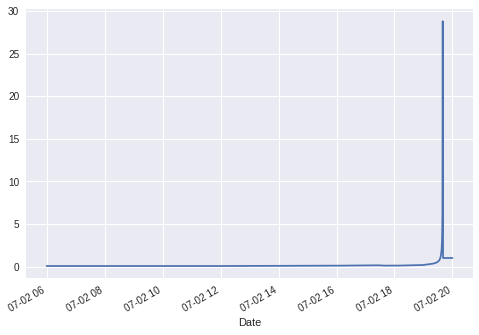

In [17]:
jour_sans.bt.plot()

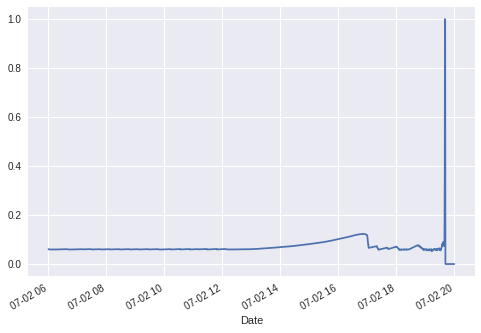

In [18]:
jour_avec.bt.plot()

Sur le premier jour par exemple, semble avoir un meilleur contrôle de la dépense avec la vitesse

##### Refaire simulation avec double algo pour faciliter la comparaison

In [40]:
def open_rtb_pacing_double_algo(env, P, B, timestampnow, nb_jours, nb_hours_per_day, bidrequests, data):
    """Fonction pour générer la simulation"""
    setup = True
    identifiant = 0
    cible = B/(nb_hours_per_day*3600)
    current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
    while True:
        # Déterminer dans quel état on est actuellement
        if current_hour >= 6 and current_hour < 20:
            if setup:
                setup = False
                lambdas_seuils = np.array([5,1,400,1,50])
                timestamps_seuils = np.array([env.now,env.now+21600,env.now+32400,env.now+39600,env.now+54000])
                f_lambdas = interp1d(timestamps_seuils, lambdas_seuils)
                current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
                S_sans = list()
                BT_sans = [cible]
                S_avec = list()
                V = [0]
                BT_avec = [cible]
                end_day = env.now + (nb_hours_per_day*3600) - 1200 #On fixe la fin de la journée à 19h40h pour être plus restrictif
            
            # Génération d'une br
            identifiant += 1
            
            # Temps restant avant la fin de la simulation
            rt = (timestampnow+total_sec(nb_jours))-env.now
            
            # Déterminer b_t
            try:
                bt_sans = (B - sum(S_sans))/(end_day - env.now)
            except ZeroDivisionError:
                bt_sans = 1
            try:
                bt_avec = (B - sum(S_avec))*((1+100*mean(V[-30:]))/(end_day - env.now))  
            except ZeroDivisionError:
                bt_avec = 1
                
            # On stocke les resultats
            BT_sans.append(bt_sans)
            BT_avec.append(bt_avec)
            
            # Calcul de la vitesse des br
            vt = BT_avec[-1] - BT_avec[-2] 
            V.append(vt)
            
            #on force l'achat
            if bt_sans < 0:
                bt_sans = 1
            if bt_avec < 0:
                bt_avec = 1
            
            #Timestamp de la br
            time = datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S")

            # Nombre d'impressions
            nb_imp = imps()
            Prix = P * nb_imp
            
            #Achat ou non 
            if bt_sans >= cible and (sum(S_sans)+Prix) <= B:
                S_sans.append(Prix)
                achat_sans = 1
            else:
                achat_sans = 0
                
            if bt_avec >= cible and (sum(S_avec)+Prix) <= B:
                S_avec.append(Prix)
                achat_avec = 1
            else:
                achat_avec = 0

            # Stocker les résultats dans le namedtuple puis ajout à une liste
            resultats = bidrequests(
                identifiant = identifiant,
                timestamp = env.now,
                timestamp_string = time,
                nombre_impressions = nb_imp,
                prix_impression = P,
                prix_total = Prix,
                cible = cible,
                achat_sans = achat_sans,
                budget_depense_sans = sum(S_sans),
                bt_sans = bt_sans,
                achat_avec = achat_avec,
                budget_depense_avec = sum(S_avec),
                bt_avec = bt_avec,
                vt = vt
            )
            data.append(resultats)

            # Temps avant la prochaine BR
            time_before_next = delai(f_lambdas(env.now))


            # Fin de la simulation
            if rt < time_before_next:
                print(f"Fin de la simulation à {time} !")

            yield env.timeout(time_before_next)
            
            # Detecter quelle heure est-t-il
            if datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour != current_hour:
                current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour

        else:
            setup = True
            current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
            time = datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S")
            rt = (timestampnow+total_sec(nb_jours))-env.now
            if rt <= 1:
                print(f"Fin de la simulation à {time} !")
            yield env.timeout(1) 

In [41]:
# Constante globales
nb_days = 30
prix_per_imp = 1
Budget_par_jour = 3000

In [42]:
timestampnow = int(time.time()-3600*6)
bidrequests =  namedtuple(
    "bidrequests", 
    (
        "identifiant", 
        "timestamp", 
        "timestamp_string",
        "nombre_impressions",
        "prix_impression",
        "prix_total",
        "cible",
        "achat_sans",
        "budget_depense_sans",
        "bt_sans",
        "achat_avec",
        "budget_depense_avec",
        "bt_avec",
        "vt"
    )
                    )
data = list()
env = simpy.Environment(initial_time=timestampnow)
proc = env.process(open_rtb_pacing_double_algo(env, prix_per_imp, Budget_par_jour, timestampnow, nb_days, 14, bidrequests, data))
env.run(until=timestampnow + total_sec(nb_days))

Fin de la simulation à 08-02-2020 05:44:01 !


In [43]:
sauvegarde(data, 'double_algo.csv')

In [44]:
data = pd.read_csv('double_algo.csv', index_col="timestamp_string", parse_dates=True)
data.index.names = ['Date']
data['budget_restant_sans'] = Budget_par_jour - data['budget_depense_sans']
data['budget_restant_avec'] = Budget_par_jour - data['budget_depense_avec']

In [45]:
data.groupby(data.index.day).tail(1)

,identifiant,timestamp,nombre_impressions,prix_impression,prix_total,cible,achat_sans,budget_depense_sans,bt_sans,achat_avec,budget_depense_avec,bt_avec,vt,budget_restant_sans,budget_restant_avec
Date,,,,,,,,,,,,,,,
2020-07-03 19:59:59,2001,1593799199,4,1,4,0.059524,0,3000,-0.0,0,3000,-0.000000,0.000000e+00,0,0
2020-07-04 19:59:59,5126,1593885599,0,1,0,0.059524,1,2974,1.0,1,2974,49.582552,7.352045e+02,26,26
2020-07-05 19:59:57,7118,1593971997,7,1,7,0.059524,1,2962,1.0,1,2959,1.000000,-6.242497e+10,38,41
2020-07-06 19:47:59,9604,1594057679,7,1,7,0.059524,0,3000,-0.0,0,3000,-0.000000,0.000000e+00,0,0
2020-07-07 19:51:29,11987,1594144289,9,1,9,0.059524,0,3000,-0.0,0,2996,0.002899,3.682523e-04,0,4
2020-07-08 19:59:21,14827,1594231161,7,1,7,0.059524,1,2970,1.0,1,2959,1.000000,2.602995e-03,30,41
2020-07-09 19:59:31,16787,1594317571,0,1,0,0.059524,1,2752,1.0,1,2726,1.000000,-1.105304e+18,248,274
2020-07-10 19:59:56,19024,1594403996,3,1,3,0.059524,0,2999,1.0,0,3000,0.000000,0.000000e+00,1,0
2020-07-11 19:59:38,21582,1594490378,5,1,5,0.059524,0,3000,-0.0,0,3000,-0.000000,0.000000e+00,0,0


Le budget restant à la fin de la journée est le même entre les deux algos avec parfois quelques euros de moins restants pour l'algo qui prend en compte la vitesse dans l'arrivée des br.

In [46]:
jour = data['2020-07-03 06:00:00':'2020-07-03 20:00:00']

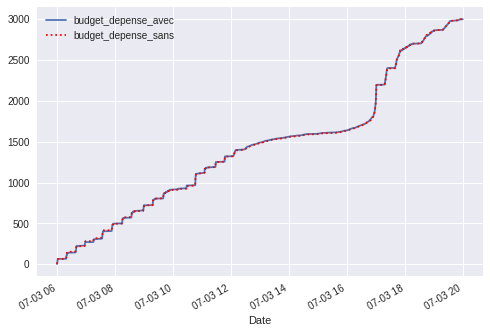

In [47]:
jour.budget_depense_avec.plot()
jour.budget_depense_sans.plot(linestyle='dotted', color='red')
plt.legend()

Les deux lignes sont confondues, globalement les deux algos se comportent de la même manière

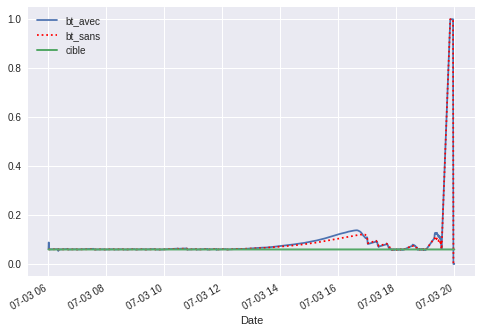

In [49]:
jour.bt_avec.plot()
jour.bt_sans.plot(linestyle='dotted', color='red')
jour.cible.plot(linewidth=2)
plt.legend()

Le changement de vitesse est très minime et donc cela n'a quasiment aucun impact sur le calcul de bt et consequemment la décison d'achat.